In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import skimage
import torch
import torchvision
import matplotlib.pyplot as plt
import torchxrayvision as xrv
import cv2

In [4]:
model = xrv.baseline_models.chestx_det.PSPNet()

In [5]:
model

chestx-det-pspnet

In [6]:
img = skimage.io.imread("../../../torchxrayvision-main/images/00000040_001.png")
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
if img.ndim == 3:
    img = img.mean(2)[None, ...] # Make single color channel
else:
    img = img[None, ...] # Already single channel

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(512)])

img = transform(img)
img = torch.from_numpy(img).float() # Ensure tensor is float32
img = img.unsqueeze(0) # Add batch dimension

In [7]:
with torch.no_grad():
    pred = model(img)

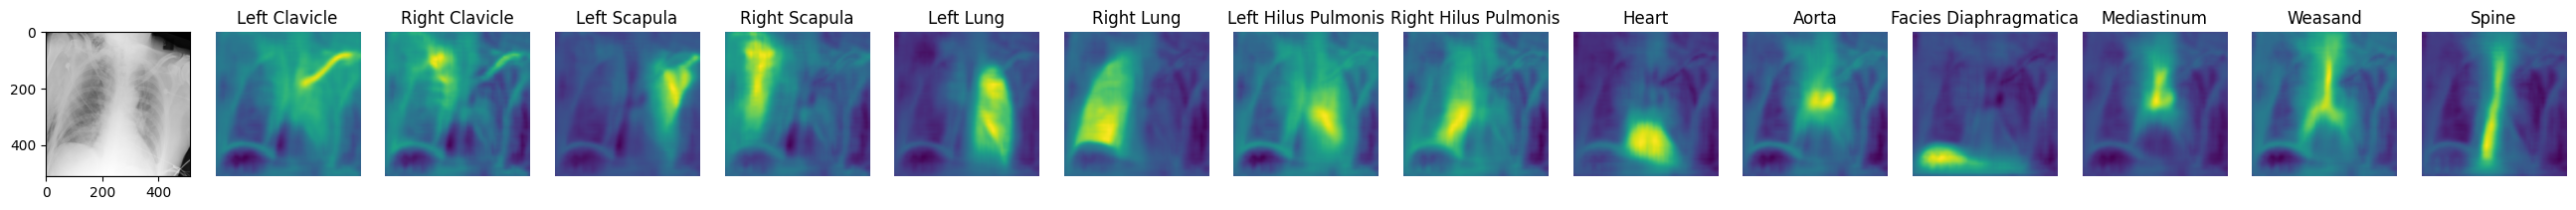

In [8]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(model.targets) + 1, 1)
# Prepare image for display (convert to numpy and squeeze channel if necessary)
if isinstance(img, torch.Tensor):
    img_disp = img[0].cpu().numpy()
else:
    img_disp = np.array(img[0])
# img_disp could be (1,H,W) or (H,W,1); squeeze to (H,W)
if img_disp.ndim == 3:
    # common channel-first (1,H,W)
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
    # channel-last (H,W,1)
    elif img_disp.shape[2] == 1:
        img_disp = img_disp[:,:,0]
plt.imshow(img_disp, cmap='gray')
for i in range(len(model.targets)):
    plt.subplot(1, len(model.targets) + 1, i+2)
    # Convert prediction to numpy if it's a torch tensor
    if isinstance(pred, torch.Tensor):
        pred_disp = pred[0, i].cpu().numpy()
    else:
        pred_disp = np.array(pred[0, i])
    plt.imshow(pred_disp)
    plt.title(model.targets[i])
    plt.axis('off')
plt.tight_layout()

In [9]:
pred = 1 / (1 + np.exp(-pred))  # sigmoid
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1

TypeError: Invalid shape (1, 512, 512) for image data

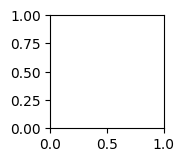

In [ ]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(model.targets) + 1, 1)
# Convert and squeeze image for display
if isinstance(img, torch.Tensor):
    img_disp = img[0].cpu().numpy()
else:
    img_disp = np.array(img[0])
if img_disp.ndim == 3:
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
    elif img_disp.shape[2] == 1:
        img_disp = img_disp[:,:,0]
plt.imshow(img_disp, cmap='gray')
for i in range(len(model.targets)):
    plt.subplot(1, len(model.targets) + 1, i+2)
    if isinstance(pred, torch.Tensor):
        pred_disp = pred[0, i].cpu().numpy()
    else:
        pred_disp = np.array(pred[0, i])
    plt.imshow(pred_disp, cmap='gray')
    plt.title(model.targets[i])
    plt.axis('off')
plt.tight_layout()

: 

: 

: 

: 

: 

: 